## Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,8)
fontsize = 18

temp_output_loc = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper/'

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the VI data.
#f_sdrq = '/global/projecta/projectdirs/sdss/staging/dr12/boss/qso/DR12Q/Superset_DR12Q.fits'
#data['VI'] = load_sdrq_data(f_sdrq)

## Load the RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q.fits'
data['RR'] = utils.load_rr_data(f_rr)

## Load the new RR data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_test.fits'
data['RRnew'] = utils.load_rr_data(f_rr)

## Load the RRngp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngp.fits'
data['RRngp'] = utils.load_rr_data(f_rr)

## Load the RRngp random exp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngprandexp.fits'
data['RRngp randexp'] = utils.load_rr_data(f_rr)

## Load the RRngp random exp data.
f_rr = temp_output_loc+'/results/rr_results/rr_sdr12q_ngpbestexp.fits'
data['RRngp bestexp'] = utils.load_rr_data(f_rr)

## Load BOSS pipeline data.
f_pipe = temp_output_loc+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
#f_pipe = '../dr14pipe_results/dr14pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_pipe)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QN'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN data.
f_qn = temp_output_loc+'/results/qn_results/qn_performance_vs_snr/qn_modelcoadd_testcoadd.fits'
data['QNcoadd'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
# TODO: Need results for SQUEzE on single exposure data.
f_sq = temp_output_loc+'/results/sq_results/sq_sdr12q.fits'
data['SQcoadd'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

INFO: 255814 common spectra


OBJ_ID,SPEC_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_RRnew,Z_RRngp,Z_RRngp randexp,Z_RRngp bestexp,Z_PIPE,Z_QN,Z_QNcoadd,Z_SQcoadd,CLASS_RR,CLASS_RRnew,CLASS_RRngp,CLASS_RRngp randexp,CLASS_RRngp bestexp,CLASS_PIPE,CLASS_QN,CLASS_QNcoadd,CLASS_SQcoadd,ISQSO_RR,ISQSO_RRnew,ISQSO_RRngp,ISQSO_RRngp randexp,ISQSO_RRngp bestexp,ISQSO_PIPE,ISQSO_QN,ISQSO_QNcoadd,ISQSO_SQcoadd,C_QN [6],C_QNcoadd [6],P_SQcoadd,ZWARN_RR,ZWARN_RRnew,ZWARN_RRngp,ZWARN_RRngp randexp,ZWARN_RRngp bestexp,ZWARN_PIPE
int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,int64,int64,int64,int64,int64,int64
391033059,3980553310001,2,0.433,GALAXY,False,0.433,0.433,0.433,0.433,0.433,0.433,0.447,0.438,0.919,GALAXY,GALAXY,GALAXY,GALAXY,GALAXY,GALAXY,QSO,NONQSO,QSO,False,False,False,False,False,False,True,False,True,0.000 .. 1.000,0.000 .. 0.902,0.803,0,0,0,0,0,0
391032962,3980553310002,2,2.371,QSO,True,1.291,0.382,0.382,0.382,0.382,2.383,2.378,2.373,2.464,QSO,GALAXY,GALAXY,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,False,False,False,False,True,True,True,True,1.000 .. 0.000,1.000 .. 0.000,0.861,0,0,0,0,0,0
391032942,3980553310003,2,0.416,QSO,True,0.416,0.416,0.416,0.416,0.416,0.416,0.418,0.409,0.420,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,0.000 .. 1.000,0.000 .. 1.000,0.742,0,0,0,0,0,0
391033364,3980553310006,2,0.000,STAR,False,-0.001,1.050,0.927,0.994,1.004,2.098,0.725,0.557,1.174,STAR,GALAXY,GALAXY,GALAXY,GALAXY,QSO,NONQSO,NONQSO,NONQSO,False,False,False,False,False,True,False,False,False,0.000 .. 0.000,0.000 .. 0.000,0.167,0,4,4,4,0,4
391032976,3980553310007,2,2.196,QSO,True,2.194,2.193,2.193,2.196,2.193,2.194,2.195,2.190,2.193,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000 .. 0.000,1.000 .. 0.000,0.993,0,0,0,0,0,0


In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

250382

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [8]:
data_table_archive = copy.deepcopy(data_table)

In [9]:
## Define parameters
n_highz_desi = 50
zcut = 2.1
dv_max = 6000. # km/s

# QN/SQ confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th_values = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

In [11]:
# Define the strategies.
stratdefs = {}

# QN definitions.
n_detect = 1
strat = strategy.Strategy('qn')
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
stratdefs['QN'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': c_th_values, 'marker': 'o'}

# RR definitions.
strat = strategy.Strategy('rr')
preds = [strat.predict(data_table)]
stratdefs['RR'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': 'k', 'marker': 'X'}

# PIPE definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'PIPE'})
preds = [strat.predict(data_table)]
stratdefs['PIPE'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                     'color': 'k', 'marker': 'P'}

# QN2line definitions.
n_detect = 2
strat = strategy.Strategy('qn')
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
stratdefs['QN2line'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                        'color': c_th_values, 'marker': 'o'}

# QNcoadd definitions.
n_detect = 1
strat = strategy.Strategy('qn',cf_kwargs={'qn_name':'QNcoadd'})
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
stratdefs['QNcoadd'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                        'color': c_th_values, 'marker': 'd'}

# SQcoadd definitions.
n_detect = 1
strat = strategy.Strategy('sq',cf_kwargs={'sq_name':'SQcoadd'})
preds = [strat.predict(data_table,c_kwargs={'p_min':c_th_value}) for c_th_value in c_th_values]
stratdefs['SQcoadd'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                        'color': c_th_values, 'marker': 'x'}

# RR|zwarn definitions.
zwarn_nonzero = data_table['ZWARN_RR']>0
stratdefs['RR|zwarn'] = {'w': [stratdefs['RR']['w'][0]|zwarn_nonzero],
                         'color': 'r', 'marker': 'X'}

# RR&~zwarn definitions.
strat = strategy.Strategy('rr')
preds = [strat.predict(data_table,c_kwargs={'zwarn':False})]
stratdefs['RR&~zwarn'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                          'color': 'b', 'marker': 'X'}

# RRngp randexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRnew'})
preds = [strat.predict(data_table)]
stratdefs['RRnew'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'k', 'marker': 'o'}

# RRngp randexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'red', 'marker': 'd'}

# RRngp randexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp randexp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp randexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                              'color': 'green', 'marker': 'd'}

# RRngp bestexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp bestexp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp bestexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                              'color': 'blue', 'marker': 'd'}

## Simple combinations.

## QN|RR definitions.
n_detect = 1
stratdefs['QN|RR'] = {'w': [w|stratdefs['RR']['w'][0] for w in stratdefs['QN']['w']],
                      'color': c_th_values, 'marker': 'x'}

## QN&RR definitions.
n_detect = 1
stratdefs['QN&RR'] = {'w': [w&stratdefs['RR']['w'][0] for w in stratdefs['QN']['w']],
                      'color': c_th_values, 'marker': 'd'}

## QN|RR randexp definitions.
n_detect = 1
stratdefs['QN|RRngp randexp'] = {'w': [w|stratdefs['RRngp randexp']['w'][0] for w in stratdefs['QN']['w']],
                      'color': c_th_values, 'marker': 'x'}

In [12]:
# Check that we haven't accidentally overwritten any data.
assert (data_table==data_table_archive).all()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


[55.6176269  50.22611703 50.0711092  49.97749061 49.90024249 49.82504067
 49.7554662  49.67975281 49.57897214 49.44852001] [0.99012656 0.98775285 0.98712872 0.98671946 0.9863102  0.98596233
 0.98546098 0.98499033 0.9842025  0.98284171]
[48.42434288] [0.96299252]
[56.15427116 50.87888926 50.74741398 50.66863112 50.60877661 50.54789895
 50.50032229 50.44507198 50.37703224 50.29978411] [0.99651104 0.995979   0.99577437 0.9956516  0.99556974 0.99548789
 0.99539581 0.99530372 0.99515025 0.99485354]
[47.88769862 47.77157064 47.7480381  47.73320237 47.71580875 47.7014846
 47.67948679 47.65902371 47.62628278 47.57307877] [0.95660804 0.95476636 0.95434687 0.95406039 0.95373298 0.95346696
 0.9530577  0.95267913 0.95204477 0.95098069]


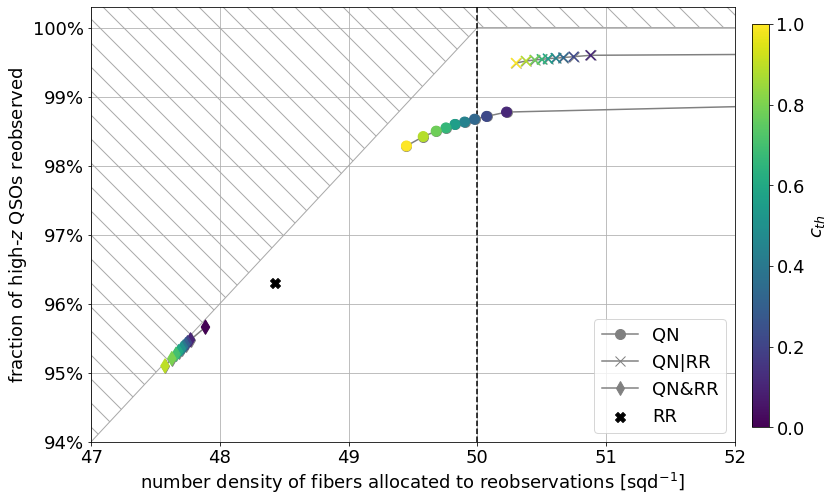

In [13]:
## Standard version of plot
plot_strategies = ['QN','RR','QN|RR','QN&RR']
filename = '../plots/classifier_performance_selecting_for_reobservation.pdf'
xmin,xmax = (47,52)
ymin = 0.94

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


[55.6176269  50.22611703 50.0711092  49.97749061 49.90024249 49.82504067
 49.7554662  49.67975281 49.57897214 49.44852001] [0.99012656 0.98775285 0.98712872 0.98671946 0.9863102  0.98596233
 0.98546098 0.98499033 0.9842025  0.98284171]
[48.42434288] [0.96299252]
[53.3278083] [0.97217021]
[48.04986852] [0.95781536]


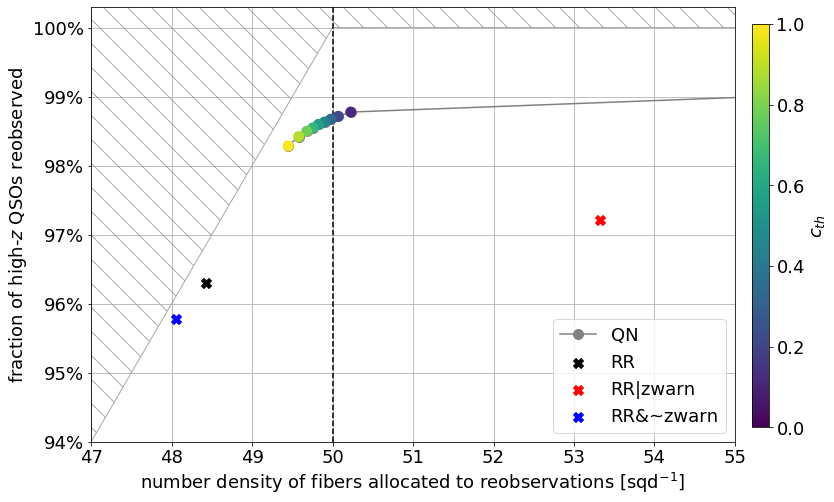

In [47]:
## Standard version of plot but with 3 RR points for including zwarn or not.
plot_strategies = ['QN','RR','RR|zwarn','RR&~zwarn']
filename = '../plots/classifier_performance_selecting_for_reobservation_zwarn.pdf'
xmin,xmax = (47,55)
ymin = 0.94

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


[55.6176269  50.22611703 50.0711092  49.97749061 49.90024249 49.82504067
 49.7554662  49.67975281 49.57897214 49.44852001] [0.99012656 0.98775285 0.98712872 0.98671946 0.9863102  0.98596233
 0.98546098 0.98499033 0.9842025  0.98284171]
[48.42434288] [0.96299252]
[51.45339022] [0.99700216]
[54.59447292 49.86903629 49.73756101 49.64701188 49.57027533 49.49353878
 49.42908008 49.34262357 49.25156287 49.09450873] [0.99011633 0.98615673 0.98523589 0.98451968 0.98392625 0.98318958
 0.98244268 0.98141952 0.98033498 0.97797149]
[53.35594504 49.98209481 49.94679599 49.93247184 49.91712453 49.8976846
 49.88540675 49.86750156 49.85010794 49.81583228] [0.99661336 0.99598924 0.99583576 0.99575391 0.9956516  0.99548789
 0.99536511 0.99521164 0.99496608 0.99445451]
[50.55301472 50.38214801 50.04246089 49.7554662  49.5042819  49.29402376
 49.03567738 48.67603876 47.99615294 46.48700083] [0.990853   0.99078138 0.98996286 0.98820303 0.98559399 0.98221758
 0.9773883  0.97038992 0.95702753 0.92720259]


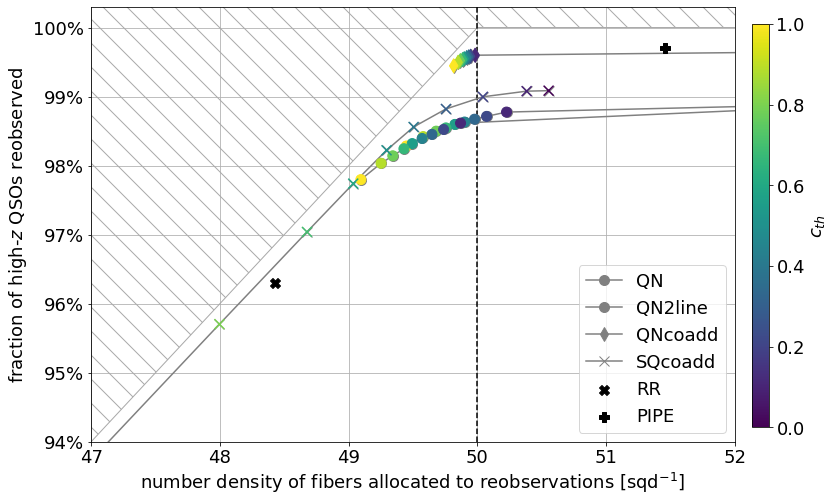

In [48]:
## Extra strategies version of plot
plot_strategies = ['QN','RR','PIPE','QN2line','QNcoadd','SQcoadd']
filename = '../plots/classifier_performance_selecting_for_reobservation_extrastrat.pdf'
xmin,xmax = (47,52)
ymin = 0.94

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


[53.35594504 49.98209481 49.94679599 49.93247184 49.91712453 49.8976846
 49.88540675 49.86750156 49.85010794 49.81583228] [0.99661336 0.99598924 0.99583576 0.99575391 0.9956516  0.99548789
 0.99536511 0.99521164 0.99496608 0.99445451]
[48.42434288] [0.96299252]
[51.45339022] [0.99700216]
[50.55301472 50.38214801 50.04246089 49.7554662  49.5042819  49.29402376
 49.03567738 48.67603876 47.99615294 46.48700083] [0.990853   0.99078138 0.98996286 0.98820303 0.98559399 0.98221758
 0.9773883  0.97038992 0.95702753 0.92720259]


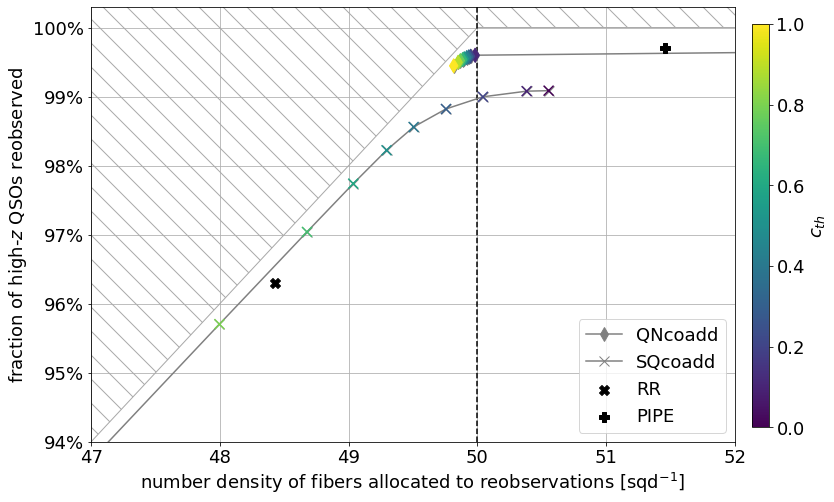

In [49]:
## Coadd only version of plot
plot_strategies = ['QNcoadd','RR','PIPE','SQcoadd']
filename = '../plots/classifier_performance_selecting_for_reobservation_coadd.pdf'
xmin,xmax = (47,52)
ymin = 0.94

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


[55.6176269  50.22611703 50.0711092  49.97749061 49.90024249 49.82504067
 49.7554662  49.67975281 49.57897214 49.44852001] [0.99012656 0.98775285 0.98712872 0.98671946 0.9863102  0.98596233
 0.98546098 0.98499033 0.9842025  0.98284171]
[48.42434288] [0.96299252]
[48.17725119] [0.95960588]
[48.17520489] [0.95944218]
[47.12749522] [0.93780247]
[47.48815699] [0.94529196]


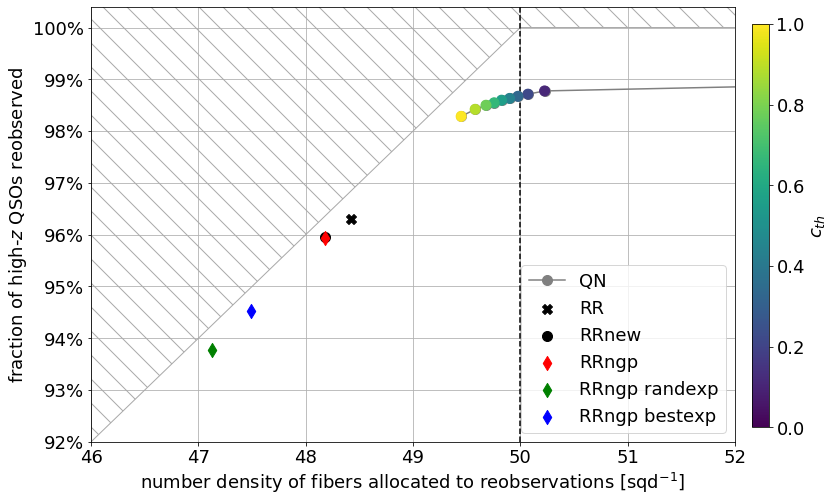

In [52]:
## Compare redrock version of plot
plot_strategies = ['QN','RR','RRnew','RRngp','RRngp randexp','RRngp bestexp']
filename = '../plots/classifier_performance_selecting_for_reobservation_rrtest.pdf'
xmin,xmax = (46,52)
ymin = 0.92

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=figsize,nydec=0)
plt.show()